In [99]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from itertools import product
from scipy.stats import poisson, ttest_ind

In [97]:
%reset -f

### Выгрузка данных и подготовка данных

In [131]:
data  = pd.read_parquet('/home/vfaybusovich/Auto ML.parquet', engine='fastparquet')
stock = pd.read_parquet('/home/vfaybusovich/Auto_ML stock.parquet', engine='fastparquet')

# работа с уценкой
discounted_goods = pd.read_excel('/home/vfaybusovich/Описательные характеристики SKU.xlsx')[['SKU_id', 'is_discounted']] 
discounted_goods_list = set(discounted_goods.query(" is_discounted == 1 ")['SKU_id'])

# убираем уценённые товары из наших датасетов
data = data.query("SKU_id not in @discounted_goods_list")
stock = stock.query("SKU_id not in @discounted_goods_list")

### Иллюстрация проблемы с дубликатами в данных
В наш датасет откуда-то затесались проблемы с дубликатами в данных. Это не ошибка при джойне, это мастер-система хранит данные о двух транзакциях. Как можно увидеть из примера, проблема состоит в SupplierID. Такого не должно существовать, одна SKU существует только для одного поставщика / селлера. Исправим эти неточности, заполнив всё одним единственным брендом, поставщиком, селлером и тд. 

In [132]:
data.query(' SKU_id == 140183682 ')

,YYYYMM,Date,Category3,Category4,Brand,SupplierID,SellerID,SKU_id,is_promo,stock_qty,GMV_wo_VAT,GMV_wo_VAT_Acc,Items_Acc
48620,202401,2024-01-01,Масла автомобильные,Автохимия - Масло моторное,Castrol,-1,0,140183682,False,92,0.000000,9142.5000,3
49719,202401,2024-01-01,Масла автомобильные,Автохимия - Масло моторное,Castrol,8984086358000,0,140183682,False,92,0.000000,0.0000,0
60818,202401,2024-01-02,Масла автомобильные,Автохимия - Масло моторное,Castrol,-1,0,140183682,False,90,0.000000,6205.8333,2
61935,202401,2024-01-02,Масла автомобильные,Автохимия - Масло моторное,Castrol,8984086358000,0,140183682,False,90,6205.833300,0.0000,0
65792,202401,2024-01-03,Масла автомобильные,Автохимия - Масло моторное,Castrol,8984086358000,0,140183682,False,87,3047.500000,0.0000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8409586,202509,2025-09-28,Масла автомобильные,Автохимия - Масло моторное,Castrol,-1,0,140183682,False,259,0.000000,14866.9999,5
8419864,202509,2025-09-29,Масла автомобильные,Автохимия - Масло моторное,Castrol,8984086358000,0,140183682,False,254,2975.833333,0.0000,0
8424817,202509,2025-09-29,Масла автомобильные,Автохимия - Масло моторное,Castrol,-1,0,140183682,False,254,0.000000,6020.8334,2
8434243,202509,2025-09-30,Масла автомобильные,Автохимия - Масло моторное,Castrol,8984086358000,0,140183682,False,252,5969.166600,0.0000,0


Eсть проблемы в двух столбцах - SupplierID (для одной SKU видим вплоть до 8 различных поставщиков), SellerID (для одной SKU видим 2 различных селлера). У данной проблемы достаточно простое решение - заполнение всех таких случаев единым ID для селлеров и поставщиков.

Шаги:
1. Находим для каждой SKU_id - SupplierID и SellerID с максимальным оборотом.
2. Заполняем все строки датасета корректными SupplierID и SellerID для каждой SKU. 
3. Формируем итоговый датасет без дубликатов через соответствующие агрегатные функции для каждой из колонок (stock_qty нужно брать как среднее для каждой даты, т.к. джойн накатывался на SKU_id)

In [133]:
data_mistakes = data \
    .groupby(['SKU_id'], as_index = False) \
    .agg({'Category3':'nunique', 'Category4': 'nunique', 'Brand': 'nunique', 'SupplierID': 'nunique', 'SellerID':'nunique'})

data_mistakes.describe()

,SKU_id,Category3,Category4,Brand,SupplierID,SellerID
count,8.663800e+04,86638.0,86638.0,86638.0,86638.000000,86638.000000
mean,1.334055e+09,1.0,1.0,1.0,1.168644,1.136072
std,5.501770e+08,0.0,0.0,0.0,0.409172,0.342867
min,1.399626e+08,1.0,1.0,1.0,1.000000,1.000000
25%,9.289548e+08,1.0,1.0,1.0,1.000000,1.000000
50%,1.417825e+09,1.0,1.0,1.0,1.000000,1.000000
75%,1.703981e+09,1.0,1.0,1.0,1.000000,1.000000
max,2.916844e+09,1.0,1.0,1.0,8.000000,2.000000


In [134]:
# Оставляем для каждой SKU один единственный SupplierID и SellerID
top_supplier_seller = data.groupby(['SKU_id', 'SupplierID', 'SellerID'], as_index=False) \
    .agg({'GMV_wo_VAT': 'sum'}) \
    .sort_values(['SKU_id', 'GMV_wo_VAT'], ascending=[True, False]) \
    .drop_duplicates(subset=['SKU_id'], keep='first')[['SKU_id', 'SupplierID', 'SellerID']]

# Объединяем с исходным датасетом, заменяя некорректные ID
data = data.drop(columns=['SupplierID', 'SellerID'])  # удаляем старые некорректные колонки
data = data.merge(top_supplier_seller, on='SKU_id', how='left')
data = data[['YYYYMM', 'Date', 'Category3', 'Category4', 'Brand', 'SupplierID', 'SellerID', 'SKU_id', 'is_promo', 'stock_qty', 'GMV_wo_VAT', 'GMV_wo_VAT_Acc', 'Items_Acc']]

# Удаляем дубликаты и агрегируем значения
data = data.groupby(['YYYYMM', 'Date', 'Category3', 'Category4', 'Brand', 'SupplierID', 'SellerID', 'SKU_id', 'is_promo'], as_index=False) \
    .agg({'stock_qty': 'mean', 'GMV_wo_VAT': 'sum', 'GMV_wo_VAT_Acc': 'sum', 'Items_Acc': 'sum'}) 

In [135]:
data.query(' SKU_id == 140183682 ')

,YYYYMM,Date,Category3,Category4,Brand,SupplierID,SellerID,SKU_id,is_promo,stock_qty,GMV_wo_VAT,GMV_wo_VAT_Acc,Items_Acc
597,202401,2024-01-01,Масла автомобильные,Автохимия - Масло моторное,Castrol,8984086358000,0,140183682,False,92.0,0.000000,9142.500000,3
10624,202401,2024-01-02,Масла автомобильные,Автохимия - Масло моторное,Castrol,8984086358000,0,140183682,False,90.0,6205.833300,6205.833300,2
21840,202401,2024-01-03,Масла автомобильные,Автохимия - Масло моторное,Castrol,8984086358000,0,140183682,False,87.0,3047.500000,18728.333200,6
33323,202401,2024-01-04,Масла автомобильные,Автохимия - Масло моторное,Castrol,8984086358000,0,140183682,False,80.0,18728.333200,3047.500000,1
45018,202401,2024-01-05,Масла автомобильные,Автохимия - Масло моторное,Castrol,8984086358000,0,140183682,False,80.0,21577.499900,28832.550067,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10086083,202509,2025-09-26,Масла автомобильные,Автохимия - Масло моторное,Castrol,8984086358000,0,140183682,True,259.0,3040.000000,3053.333300,1
10103769,202509,2025-09-27,Масла автомобильные,Автохимия - Масло моторное,Castrol,8984086358000,0,140183682,False,258.0,2887.500000,15389.166600,5
10121099,202509,2025-09-28,Масла автомобильные,Автохимия - Масло моторное,Castrol,8984086358000,0,140183682,False,259.0,15221.666700,14866.999900,5
10138638,202509,2025-09-29,Масла автомобильные,Автохимия - Масло моторное,Castrol,8984086358000,0,140183682,False,254.0,2975.833333,6020.833400,2


### Создание "полотна"
Мы создаём для каждой пары sku_id и даты отдельную строку в датасете. В качестве результата получаем датасет из двух столбцов 'SKU_id' и 'date'. На данном этапе учитываются абсолютно все такие пары (если SKU появилась в 25-ом году, то на данном этапе для неё будут все даты и в 24-ом году).

In [136]:
# Переименовываем колонку
stock = stock.rename(columns = {'DATE': 'date'})

# Получаем уникальные товары
unique_items = data['SKU_id'].unique()

# Создаем полный диапазон дат
date_range = pd.date_range(start = '2024-01-01', end = '2025-09-30', freq='D')

# Создаем MultiIndex со всеми комбинациями товар-дата
multi_index = pd.MultiIndex.from_product([unique_items, date_range], names = ['SKU_id', 'date'])

# Создаем полный датафрейм-шаблон
complete_template = pd.DataFrame(index=multi_index).reset_index()

### Наполнение "полотна" данными по стокам

На данном этапе мы:
1. Джойним стоки к нашему полотну с предыдущего этапа
2. Убираем даты, в котороые стока не существовало (минимальная дата для каждой SKU = дата первого появления стоков SKU)

In [137]:
# Приводим даты к datetime в обоих датафреймах
complete_template['date'] = pd.to_datetime(complete_template['date'])
stock['date'] = pd.to_datetime(stock['date'])

# Переименовываем колонку
stock = stock.rename(columns={'DATE': 'date'})

# Теперь объединяем
merged_df = pd.merge(
    complete_template,
    stock[['SKU_id', 'date', 'stock_qty']],
    on=['SKU_id', 'date'],
    how='left'
)

# Заполняем пропуски нулями
merged_df['stock_qty'] = merged_df['stock_qty'].fillna(0)

# Находим первую дату с положительным стоком для каждого товара
first_stock_dates = merged_df[merged_df['stock_qty'] > 0].groupby('SKU_id')['date'].min()

# Создаем Series с первой датой для каждого товара
first_dates_series = merged_df['SKU_id'].map(first_stock_dates)

# Фильтруем: оставляем только строки, где дата >= первой даты с стоком
mask = (merged_df['date'] >= first_dates_series) | first_dates_series.isna()

# Применяем фильтр
filtered_df = merged_df[mask].copy()

### Создаём датасет с информацией о перерывах в наличии товара на стоке

In [138]:
def analyze_stock_breaks_fast(filtered_df):
    """
    Быстрый анализ перерывов между днями наличия стока
    """
    # 1. Фильтруем только дни, когда сток был > 0
    stock_days = filtered_df[filtered_df['stock_qty'] > 0].copy()
    
    # 2. Сортируем по товару и дате для корректного вычисления разниц
    stock_days = stock_days.sort_values(['SKU_id', 'date'])
    
    # 3. Вычисляем разницу в днях между последовательными днями с стоком
    # для каждого товара отдельно
    stock_days['days_between_stock'] = stock_days.groupby('SKU_id')['date'].diff().dt.days
    
    # 4. Убираем NaN значения (первые дни для каждого товара)
    breaks_with_nan = stock_days['days_between_stock'].dropna()
    
    # 5. Вычитаем 1 день, потому что нам нужен перерыв между днями,
    # а не разница в датах
    # Пример: даты 01-01 и 01-03 -> разница 2 дня, но перерыв 1 день (02-01)
    breaks_with_gaps = breaks_with_nan - 1
    
    # 6. Фильтруем только положительные перерывы (> 0 дней)
    # Исключаем последовательные дни (перерыв = 0)
    positive_breaks = breaks_with_gaps[breaks_with_gaps > 0]
    
    print(f"Найдено перерывов: {len(positive_breaks)}")
    
    return positive_breaks

breaks_series = analyze_stock_breaks_fast(filtered_df)

Найдено перерывов: 268141


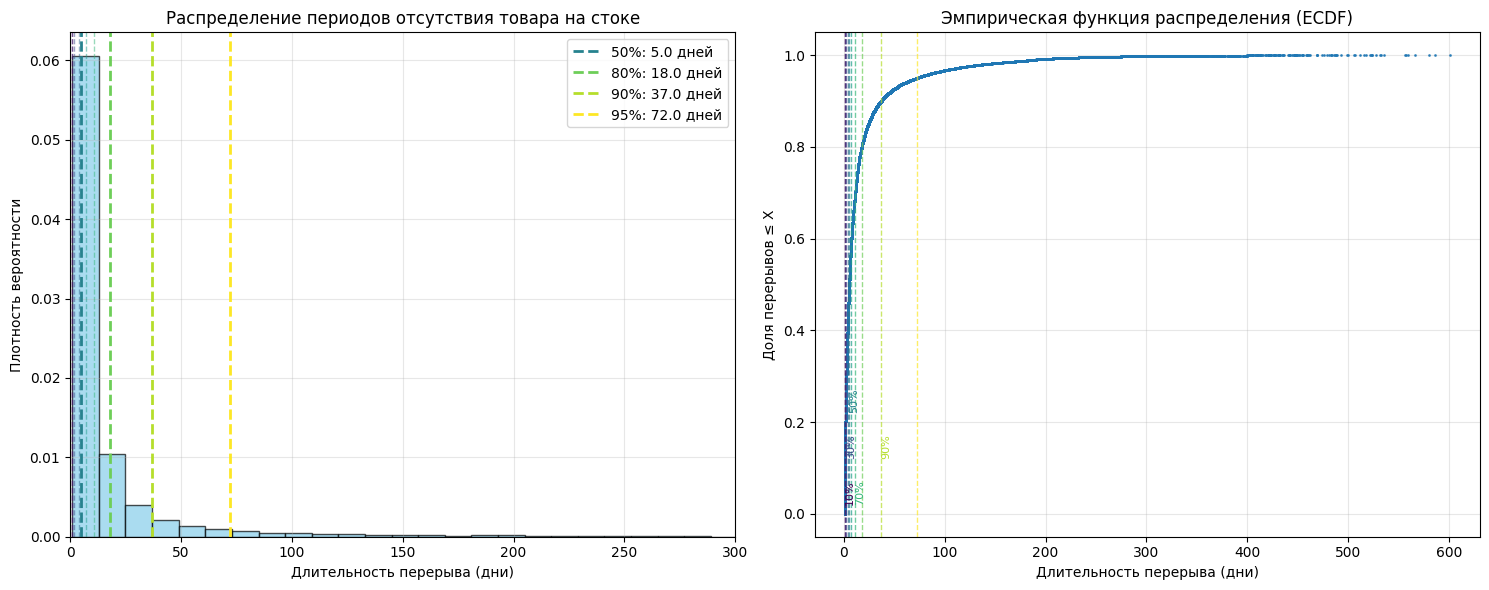

Детальная статистика перерывов:
Общее количество перерывов: 268141
Минимальный перерыв: 1.0 дней
Максимальный перерыв: 601.0 дней
Средний перерыв: 16.3 дней
Медиана перерывов: 5.0 дней

Перцентили:
  10%: 1.0 дней
  20%: 1.0 дней
  30%: 2.0 дней
  40%: 4.0 дней
  50%: 5.0 дней
  60%: 7.0 дней
  70%: 11.0 дней
  80%: 18.0 дней
  90%: 37.0 дней
  95%: 72.0 дней


In [139]:
def plot_breaks_distribution(breaks_series):
    """
    Визуализирует распределение перерывов между периодами стока
    """
    
    # Вычисляем перцентили
    percentiles = {
        '10%': breaks_series.quantile(0.10),
        '20%': breaks_series.quantile(0.20),
        '30%': breaks_series.quantile(0.30),
        '40%': breaks_series.quantile(0.40),
        '50%': breaks_series.quantile(0.50),
        '60%': breaks_series.quantile(0.60),
        '70%': breaks_series.quantile(0.70), 
        '80%': breaks_series.quantile(0.80),
        '90%': breaks_series.quantile(0.90),
        '95%': breaks_series.quantile(0.95)
    }
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # 1. Гистограмма с перцентилями
    n, bins, patches = ax1.hist(breaks_series, bins=50, alpha=0.7, color='skyblue', edgecolor='black', density=True)
    
    # Цвета для перцентилей
    colors = plt.cm.viridis(np.linspace(0, 1, len(percentiles)))
    
    # Отображаем только ключевые перцентили на легенде чтобы не перегружать
    key_percentiles = {'50%': '50%', '80%': '80%', '90%': '90%', '95%': '95%'}
    
    for i, (label, value) in enumerate(percentiles.items()):
        color = colors[i]
        if label in key_percentiles:
            ax1.axvline(value, color=color, linestyle='--', linewidth=2, 
                       label=f'{label}: {value:.1f} дней')
        else:
            ax1.axvline(value, color=color, linestyle='--', linewidth=1, alpha=0.5)
    
    ax1.set_xlabel('Длительность перерыва (дни)')
    ax1.set_ylabel('Плотность вероятности')
    ax1.set_title('Распределение периодов отсутствия товара на стоке')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.set_xlim(0, 300)
    
    # 2. Эмпирическая функция распределения (ECDF)
    sorted_breaks = np.sort(breaks_series)
    y = np.arange(1, len(sorted_breaks) + 1) / len(sorted_breaks)
    
    ax2.plot(sorted_breaks, y, marker='.', linestyle='none', alpha=0.8, markersize=2)
    ax2.set_xlabel('Длительность перерыва (дни)')
    ax2.set_ylabel('Доля перерывов ≤ X')
    ax2.set_title('Эмпирическая функция распределения (ECDF)')
    ax2.grid(True, alpha=0.3)
    
    # Добавляем все перцентили на ECDF
    for i, (label, value) in enumerate(percentiles.items()):
        color = colors[i]
        ax2.axvline(value, color=color, linestyle='--', linewidth=1, alpha=0.7)
        if i % 2 == 0:
            ax2.text(value, 0.02 + (i * 0.05) % 0.3, f'{label}', 
                    rotation=90, va='bottom', color=color, fontsize=8)
    
    plt.tight_layout()
    plt.show()
    
    # Статистика
    print("Детальная статистика перерывов:")
    print(f"Общее количество перерывов: {len(breaks_series)}")
    print(f"Минимальный перерыв: {breaks_series.min():.1f} дней")
    print(f"Максимальный перерыв: {breaks_series.max():.1f} дней")
    print(f"Средний перерыв: {breaks_series.mean():.1f} дней")
    print(f"Медиана перерывов: {breaks_series.median():.1f} дней")
    print("\nПерцентили:")
    for label, value in percentiles.items():
        print(f"  {label}: {value:.1f} дней")
    
    return percentiles

# Запускаем визуализацию
percentiles = plot_breaks_distribution(breaks_series)

### Принятие решения о буферном периоде для восстановления спроса

Как можно увидеть, использование в качестве буферного периода промежутка в 11 дней позволит нам покрыть 70% всех периодов отсутствия товара на складе. Данный промежуток времени кажется наиболее оптимальным с точки зрения реальности восстановления реального спроса на данный товар. На более длинных горизонтах времени в игру вступает всё большее количество иных факторов (сезонность, алгоритмы продвижения в поиске и прочие). 

Я использую следующую логику в функции ниже:
- Сортирую датасет по SKU и дате
- Если в датасете товар отсутствует больше 11 дней подряд -> удаляем эти строки
- Иначе - оставляем строки для дальнейшего восстановления спроса

In [142]:
def remove_long_stock_breaks_by_zero_runs(df, max_break_days=11):
    d = df.copy()
    d["date"] = pd.to_datetime(d["date"])
    d = d.sort_values(["SKU_id", "date"])
 
    d["is_zero"] = d["stock_qty"].fillna(0).eq(0)
 
    # id блока (меняется, когда is_zero меняется) внутри каждого SKU
    d["run_id"] = (
        d.groupby("SKU_id")["is_zero"]
         .apply(lambda s: s.ne(s.shift()).cumsum())
         .reset_index(level=0, drop=True)
    )
 
    # длина блока
    d["run_len"] = d.groupby(["SKU_id", "run_id"])["is_zero"].transform("size")
 
    # удалить нулевые блоки, которые длиннее порога
    mask_remove = d["is_zero"] & (d["run_len"] > max_break_days)
 
    out = d.loc[~mask_remove].drop(columns=["is_zero", "run_id", "run_len"])
    return out

# Запускаем очистку
cleaned_df = remove_long_stock_breaks_by_zero_runs(filtered_df, max_break_days=11)

### Джойним с продажами, помечаем дни дефицита

In [144]:
data = data.rename(columns = {'Date': 'date'})
data['date'] = pd.to_datetime(data['date'])

cleaned_df = pd.merge(
    cleaned_df,
    data[['date', 'SKU_id', 'Items_Acc']],
    on=['SKU_id', 'date'],
    how='left',
).fillna(0)


def add_iterative_stock_deficit_flag(
    df: pd.DataFrame,
    sku_col: str = 'SKU_id',
    date_col: str = 'date',
    demand_col: str = 'Items_Acc',
    stock_col: str = 'stock_qty',
    lookback_days: int = 7,
    min_obs: int = 3,
    median_col: str = 'items_acc_median_prev7d_nondef',
    deficit_col: str = 'deficit',
) -> pd.DataFrame:
    """Итеративный признак дефицита по SKU.

    Для каждой SKU и даты считаем медиану demand_col за предыдущие lookback_days календарных дней
    (текущая дата не включается) по дням, которые ранее были помечены как non-deficit.

    Если stock на текущую дату < этой медианы -> deficit=1.
    Если данных для медианы меньше min_obs -> cold-start: deficit = (stock==0).

    Возвращает df с колонками median_col и deficit_col.
    """

    delta = pd.Timedelta(days=lookback_days)

    def process_group(g: pd.DataFrame) -> pd.DataFrame:
        g = g.sort_values(date_col).copy()

        # список (date, demand) только для ранее определённых non-deficit
        prev_nondef: list[tuple[pd.Timestamp, float]] = []
        medians: list[float] = []
        deficits: list[int] = []

        for r in g.itertuples(index=False):
            cur_date = getattr(r, date_col)
            cur_stock = getattr(r, stock_col)
            cur_demand = getattr(r, demand_col)

            window_start = cur_date - delta
            prev_nondef = [(d, v) for d, v in prev_nondef if d >= window_start]
            vals = [v for _, v in prev_nondef]

            if len(vals) >= min_obs:
                med = float(np.median(vals))
            else:
                med = np.nan

            medians.append(med)

            if pd.isna(med):
                dflag = int(cur_stock == 0)
            else:
                dflag = int(cur_stock < med)

            deficits.append(dflag)

            # текущую дату добавляем только если она non-deficit
            if dflag == 0:
                prev_nondef.append((cur_date, float(cur_demand)))

        g[median_col] = medians
        g[deficit_col] = deficits
        return g

    return df.groupby(sku_col, group_keys=False).apply(process_group)


cleaned_df = add_iterative_stock_deficit_flag(cleaned_df)
cleaned_df.head()

,SKU_id,date,stock_qty,Items_Acc,deficit
0,139962554,2024-08-29,1.0,0.0,0
1,139962554,2024-08-30,1.0,2.0,0
2,139962554,2024-08-31,1.0,1.0,0
3,139962554,2024-09-01,1.0,0.0,0
4,139962554,2024-09-02,1.0,0.0,0


### Работа над спросом

In [145]:
def add_lambda_corrected_grouped_median(df, window=30, min_obs=10):
    """
    Robust lambda: rolling median по non-deficit дням + ffill через дефицит.
    Cold-start НЕ заполняем: если non-deficit наблюдений < min_obs -> lambda_corrected = NaN
    Требует: RezonItemID, date, Items_Acc, deficit
    """
    def process_group(g):
        g = g.sort_values("date").copy()
 
        # наблюдаемые продажи: дефицит -> NaN (не “0 спрос”)
        y_obs = g["Items_Acc"].where(g["deficit"] == 0)
 
        # если товара “слишком мало” без-дефицитных дней — не оцениваем вообще
        if y_obs.notna().sum() < min_obs:
            g["lambda_estimate"] = np.nan
            g["lambda_corrected"] = np.nan
            return g
 
        # rolling median (робастно к всплескам)
        lam = y_obs.rolling(window=window, min_periods=min_obs).median()
 
        # держим последнюю оценку на дефицитных блоках (не угасает)
        lam = lam.ffill()
 
        g["lambda_estimate"] = lam
 
        # в дефицит -> lambda, иначе -> факт
        g["lambda_corrected"] = np.where(
            g["deficit"] == 1,
            g["lambda_estimate"],
            g["Items_Acc"]
        )
        return g
 
    return df.groupby("SKU_id", group_keys=False).apply(process_group)

# Вызов функции
result_df = add_lambda_corrected_grouped_median(cleaned_df, window=30, min_obs=10)

# Удаляем 211 пропущенных значений lambda_corrected
# Это новые товары, появившиеся только в сентябре, о них нет никакой информации
result_df = result_df[result_df['lambda_corrected'].notna()]

/tmp/ipykernel_261008/3983573421.py:35: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby("SKU_id", group_keys=False).apply(process_group)


In [146]:
# ----------------------------------------------------------------------
# ------------------------ СЭМПЛИРОВАНИЕ СПРОСА ------------------------
# ----------------------------------------------------------------------

def restore_demand_grouped(df):
    """Сэмплирование спроса из распределения Пуассона для всех товаров"""
    
    def process_demand_group(group):
        """Обрабатывает одну группу (один товар)"""
        product_data = group.copy()
        
        # Используем lambda_corrected
        lambda_value = product_data["lambda_corrected"].values
        sales_oracle_day = product_data["Items_Acc"].fillna(0).values
        max_sales = product_data["Items_Acc"].max()
        
        # Сэмплирование из Пуассона
        product_data["demand"] = np.fmin(
            np.full(len(lambda_value), max_sales),  # Ограничение сверху
            np.fmax(
                np.random.poisson(lambda_value, size=len(lambda_value)),
                sales_oracle_day  # Ограничение снизу - фактические продажи
            )
        )
        
        return product_data
    
    # Применяем функцию ко всем группам
    result_df = df.groupby('RezonItemID').apply(process_demand_group).reset_index(drop=True)
    
    return result_df

# Использование:
result_df = restore_demand_grouped(result_df)

/tmp/ipykernel_261008/3077001409.py:29: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result_df = df.groupby('SKU_id').apply(process_demand_group).reset_index(drop=True)


In [ ]:
result_df['real_demand'] = np.where(
            result_df['deficit'] == 1,
            result_df['demand'],         # если есть дефицит -> спрос = посчитанный спрос по Пуассону
            result_df['Items_Acc']       # если нет дефицита -> спрос = фактические продажи
        )

result_df

,SKU_id,date,stock_qty,Items_Acc,deficit,lambda_estimate,lambda_corrected,demand,real_demand
0,139962656,2024-08-27,1.0,1.0,0,NaN,1.0,1.0,1.0
1,139962656,2024-08-28,1.0,0.0,0,NaN,0.0,0.0,0.0
2,139962656,2024-09-15,1.0,0.0,0,NaN,0.0,0.0,0.0
3,139962656,2024-09-16,1.0,0.0,0,NaN,0.0,0.0,0.0
4,139962656,2024-09-17,1.0,0.0,0,NaN,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
26365515,2871556848,2025-09-26,3.0,0.0,0,NaN,0.0,0.0,0.0
26365516,2871556848,2025-09-27,3.0,0.0,0,NaN,0.0,0.0,0.0
26365517,2871556848,2025-09-28,3.0,0.0,0,NaN,0.0,0.0,0.0
26365518,2871556848,2025-09-29,3.0,0.0,0,0.0,0.0,0.0,0.0


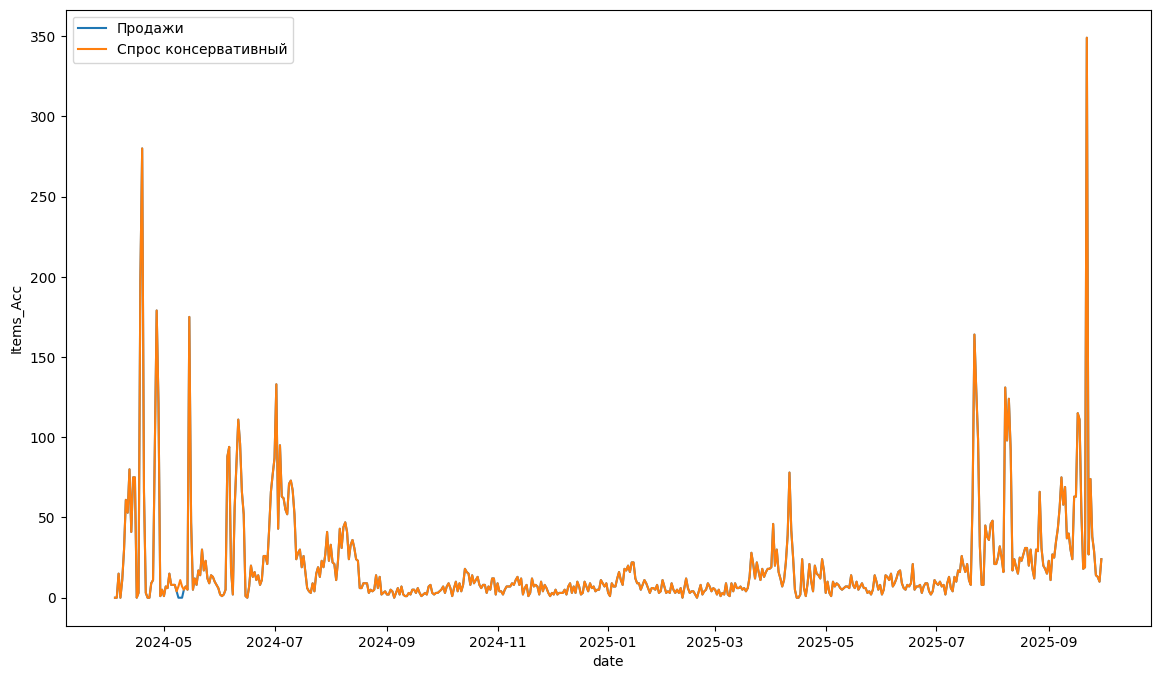

In [205]:
import seaborn as sns

plt.figure(figsize=(14, 8))
sns.lineplot(x = 'date', y = 'Items_Acc', data = result_df.query(" SKU_id == 1525269970"), label = 'Продажи')
sns.lineplot(x = 'date', y = 'real_demand', data = result_df.query(" SKU_id == 1525269970"), label = 'Спрос консервативный')
plt.legend()

In [172]:
result_df.query(" SKU_id == 907323049 & date >= '2024-08-01' ").head(50)

,SKU_id,date,stock_qty,Items_Acc,deficit,lambda_estimate,lambda_corrected,demand,real_demand
8429790,907323049,2024-08-01,1370.0,107.0,0,115.0,107.0,107.0,107.0
8429791,907323049,2024-08-02,1276.0,109.0,0,114.0,109.0,112.0,109.0
8429792,907323049,2024-08-03,1169.0,108.0,0,112.0,108.0,123.0,108.0
8429793,907323049,2024-08-04,1081.0,99.0,0,112.0,99.0,99.0,99.0
8429794,907323049,2024-08-05,999.0,124.0,0,112.0,124.0,128.0,124.0
8429795,907323049,2024-08-06,888.0,127.0,0,112.0,127.0,141.0,127.0
8429796,907323049,2024-08-07,755.0,118.0,0,112.0,118.0,136.0,118.0
8429797,907323049,2024-08-08,650.0,131.0,0,112.0,131.0,131.0,131.0
8429798,907323049,2024-08-09,538.0,130.0,0,112.0,130.0,130.0,130.0
8429799,907323049,2024-08-10,404.0,167.0,0,112.0,167.0,167.0,167.0
